In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds

## Load and Preprocess the Dataset

In [2]:
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"

# Downloads the file from a URL using
data_file = tf.keras.utils.get_file('breast_cancer.csv', DATASET_URL)
col_names = ["id", "clump_thickness", "un_cell_size", "un_cell_shape", "marginal_adheshion", 
             "single_eph_cell_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli", 
             "mitoses", "class"]
df = pd.read_csv(data_file, names=col_names, header=None)
df.head()

,id,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
# delete 'id' column
df.pop('id')

0      1000025
1      1002945
2      1015425
3      1016277
4      1017023
        ...   
694     776715
695     841769
696     888820
697     897471
698     897471
Name: id, Length: 699, dtype: int64

In [5]:
# bare_nuclei column has some unknown values, thes rows need to be dropped
df = df[df['bare_nuclei'] != '?']
df.bare_nuclei = pd.to_numeric(df.bare_nuclei)

There are two classes, 2.0 and 4.0 According to the dataset:

- 2.0 = benign
- 4.0 = malignant

In [6]:
# get classes value 
df['class'].unique()

array([2, 4], dtype=int64)

<AxesSubplot:>

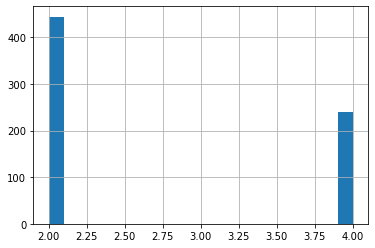

In [7]:
# get the distribution of classes
df['class'].hist(bins=20)

In [8]:
# change classes to be 0 for bengin, 1 for maligant
df['class'] = np.where(df['class'] == 2, 0, 1)

In [9]:
# split the dataset into training and testing sets
train, test = train_test_split(df, test_size = 0.2)

In [10]:
# get the statistics of the training dataset
train_stats = train.describe()
train_stats.pop('class')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
clump_thickness,546.0,4.476190,2.801111,1.0,2.0,4.0,6.00,10.0
un_cell_size,546.0,3.210623,3.087940,1.0,1.0,1.0,5.00,10.0
un_cell_shape,546.0,3.274725,3.022482,1.0,1.0,1.0,5.00,10.0
marginal_adheshion,546.0,2.813187,2.842323,1.0,1.0,1.0,3.75,10.0
single_eph_cell_size,546.0,3.265568,2.246503,1.0,2.0,2.0,4.00,10.0
bare_nuclei,546.0,3.587912,3.656910,1.0,1.0,1.0,7.00,10.0
bland_chromatin,546.0,3.465201,2.456162,1.0,2.0,3.0,5.00,10.0
normal_nucleoli,546.0,2.941392,3.078223,1.0,1.0,1.0,4.00,10.0
mitoses,546.0,1.681319,1.854600,1.0,1.0,1.0,1.00,10.0


We pop the class column from the training and test sets to create train and test outputs.

In [11]:
# pop the class column from the training and test sets to create train and test outputs
train_Y = train.pop('class')
test_y = test.pop('class')

In [12]:
# normalise the data 
def norm(x):
    x = (x - train_stats['mean']) / train_stats['std']
    return x

In [13]:
norm_train_X = norm(train)
norm_test_X = norm(test)

In [14]:
# create Tensorflow datasets for training and test sets to easily be able to build and manage an input pipeline for our model.
train_dataset = tf.data.Dataset.from_tensor_slices((norm_train_X, train_Y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((norm_test_X, test_y.values))

In [15]:
# shuffle and prepare a batched dataset
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [16]:
a = enumerate(train_dataset)
print(len(list(a)))

18


## Building the model

In [17]:
def base_model():
    inputs = tf.keras.layers.Input(shape=(len(train.columns)))
    
    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

model = base_model()

In [60]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.BinaryCrossentropy()

## Define Metrics 

In [63]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

In [78]:
class F1Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        '''initializes attributes of the class'''
        
        # call the parent class init
        super(F1Score, self).__init__(name=name, **kwargs)

        # Initialize Required variables
        # true positives
        self.tp = tf.Variable(0, dtype = 'int32')
        # false positives
        self.fp = tf.Variable(0, dtype = 'int32')
        # true negatives
        self.tn = tf.Variable(0, dtype = 'int32')
        # false negatives
        self.fn = tf.Variable(0, dtype = 'int32')

        
    def update_state(self, y_true, y_pred, sample_weight=None):
        '''
        Accumulates statistics for the metric
        
        Args:
            y_true: target values from the test data
            y_pred: predicted values by the model
        '''
        # Calulcate confusion matrix.
        conf_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)
        
        # Update values of true positives, true negatives, false positives and false negatives from confusion matrix.
        self.tn.assign_add(conf_matrix[0][0])
        self.tp.assign_add(conf_matrix[1][1])
        self.fp.assign_add(conf_matrix[0][1])
        self.fn.assign_add(conf_matrix[1][0])
        
    def result(self):
        '''Computes and returns the metric value tensor.'''

        # Calculate precision
        if (self.tp + self.fp == 0):
            precision = 1.0
        else:
            precision = self.tp / (self.tp + self.fp)
      
        # Calculate recall
        if (self.tp + self.fn == 0):
            recall = 1.0
        else:
            recall = self.tp / (self.tp + self.fn)

        # Return F1 Score
        ### START CODE HERE ###
        f1_score = 2 * ((precision * recall) / (precision + recall))
        ### END CODE HERE ###
        
        return f1_score
    
    def reset_states(self):
        '''Resets all of the metric state variables.'''
        
        # The state of the metric will be reset at the start of each epoch.
        self.tp.assign(0)
        self.tn.assign(0) 
        self.fp.assign(0)
        self.fn.assign(0)            

In [80]:
train_f1score_metric = F1Score()
val_f1score_metric = F1Score()

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

## Apply Gradients

In [86]:
def apply_gradient(optimizer, loss_object, model, x, y):
    '''
    applies the gradients to the trainable model weights
    
    Args:
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        x: input data to the model
        y: target values for each input
    '''
    
    with tf.GradientTape() as tape:
        logits = model(x)
        loss_value = loss_object(y_true = y, y_pred=logits)
        
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    return logits, loss_value

## Training Loop

In [97]:
def train_data_for_one_epoch(train_dataset, optimizer, loss_object, model, 
                             train_acc_metric, train_f1score_metric, verbose=True):
    
    '''
    Computes the loss then updates the weights and metrics for one epoch.
    
    Args:
        train_dataset: the training dataset
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        train_acc_metric: calculates how often predictions match labels
        train_f1score_metric: custom metric we defined earlier
    '''
    
    losses = []
    
    #Iterate through all batches of training data
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        #Calculate loss and update trainable variables using optimizer
        logits, loss_value = apply_gradient(optimizer, loss_object, model, x_batch_train, y_batch_train)
        losses.append(loss_value)
        
        #Round off logits to nearest integer and cast to integer for calulating metrics
        logits = tf.round(logits)
        logits = tf.cast(logits, 'int64')
        
        #Update the training metrics
        train_acc_metric.update_state(y_batch_train, logits)
        train_f1score_metric.update_state(y_batch_train, logits)
        
         #Update progress
        if verbose:
            print("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
    
    return losses

In [102]:
def perform_validation():
    """
    The function calculates the loss on test dataset and updates the states of the validation metrics.
    """
    losses = []
    
    # iterate through every batch in test dataset
    for x_val, y_val in test_dataset:
        val_logits = model(x_val)
        val_loss = loss_object(y_true = y_val, y_pred = val_logits)
        losses.append(val_loss)
        
        #Round off and cast outputs to either  or 1
        val_logits = tf.cast(tf.round(val_logits), 'int64')
        
        #Update validation metrics
        val_acc_metric.update_state(y_val, val_logits)
        val_f1score_metric.update_state(y_val, val_logits)
        
    return losses

In [103]:
# Iterate over epochs.
epochs = 5
epochs_val_losses, epochs_train_losses = [], []

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    #Perform Training over all batches of train data
    losses_train = train_data_for_one_epoch(train_dataset, optimizer, loss_object, model, 
                                            train_acc_metric, train_f1score_metric, verbose=True)
    
    # Get results from training metrics
    train_acc = train_acc_metric.result()
    train_f1score = train_f1score_metric.result()
    
    #Perform validation on all batches of test data
    losses_val = perform_validation()
    
    # Get results from validation metrics
    val_acc = val_acc_metric.result()
    val_f1score = val_f1score_metric.result()
    
    #Calculate training and validation losses for current epoch
    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)

    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f, Train F1 Score: %.4f, Validation F1 Score: %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc), train_f1score, val_f1score))

    #Reset states of all metrics
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()
    val_f1score_metric.reset_states()
    train_f1score_metric.reset_states()

Start of epoch 0
Training loss for step 0: 0.1121
Training loss for step 1: 0.0444
Training loss for step 2: 0.1170
Training loss for step 3: 0.0127
Training loss for step 4: 0.2000
Training loss for step 5: 0.0195
Training loss for step 6: 0.1820
Training loss for step 7: 0.0346
Training loss for step 8: 0.0137
Training loss for step 9: 0.0484
Training loss for step 10: 0.1909
Training loss for step 11: 0.0218
Training loss for step 12: 0.0088
Training loss for step 13: 0.0261
Training loss for step 14: 0.0261
Training loss for step 15: 0.0721
Training loss for step 16: 0.1704
Training loss for step 17: 0.2453

 Epoch 0: Train loss: 0.0859  Validation Loss: 0.0370, Train Accuracy: 0.9679, Validation Accuracy 0.9937, Train F1 Score: 0.9499, Validation F1 Score: 0.9912
Start of epoch 1
Training loss for step 0: 0.0337
Training loss for step 1: 0.0857
Training loss for step 2: 0.0953
Training loss for step 3: 0.0849
Training loss for step 4: 0.0536
Training loss for step 5: 0.2164
Traini

## Evaluate the Model

### Plots for Evaluation

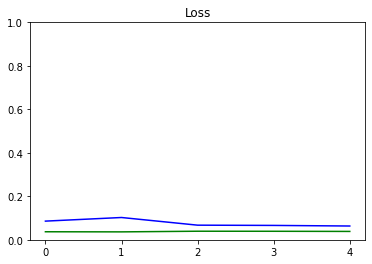

In [105]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric,color='blue',label=metric_name)
    plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

C:\Users\rodan\Anaconda3\envs\CV\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
C:\Users\rodan\Anaconda3\envs\CV\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


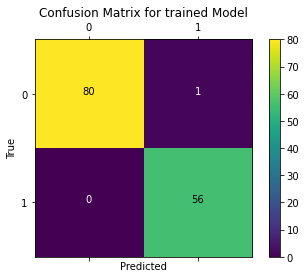

In [108]:
test_outputs = model(norm_test_X.values)
plot_confusion_matrix(test_y.values, tf.round(test_outputs), title='Confusion Matrix for trained Model')